In [1]:
import arrayfire as af
import numpy as np
import h5py
import pylab as pl

%matplotlib inline

In [2]:
from bolt.lib.physical_system import physical_system
from bolt.lib.nonlinear_solver.nonlinear_solver import nonlinear_solver
from bolt.lib.linear_solver.linear_solver import linear_solver

In [3]:
import bolt.src.nonrelativistic_boltzmann.advection_terms as advection_terms
import bolt.src.nonrelativistic_boltzmann.collision_operator as collision_operator
import bolt.src.nonrelativistic_boltzmann.moment_defs as moment_defs

In [4]:
import domain
import boundary_conditions
import params
import initialize

In [7]:
# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [5]:
# Time parameters:
t_final = 0.1
N       = 2**np.arange(5, 10)

In [6]:
for i in range(N.size):
    domain.N_q1 = int(N[i])
    domain.N_p1 = int(N[i])

    dt = 1e-3/(2**i)

    # Defining the physical system to be solved:
    system = physical_system(domain,
                             boundary_conditions,
                             params,
                             initialize,
                             advection_terms,
                             collision_operator.BGK,
                             moment_defs
                            )

    linearized_system = physical_system(domain,
                                        boundary_conditions,
                                        params,
                                        initialize,
                                        advection_terms,
                                        collision_operator.linearized_BGK,
                                        moment_defs
                                       )

    nls = nonlinear_solver(system)
    ls  = linear_solver(system)

    time_array = np.arange(dt, t_final + dt, dt)

    for time_index, t0 in enumerate(time_array):
        nls.strang_timestep(dt)
        ls.RK4_timestep(dt)

    nls.dump_distribution_function('dump_files/nlsf_' + str(N[i]))
    ls.dump_distribution_function('dump_files/lsf_' + str(N[i]))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hyperion/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-54cf89183170>", line 32, in <module>
    nls.strang_timestep(dt)
  File "/home/hyperion/git_repos/Bolt/bolt/lib/nonlinear_solver/timestep.py", line 219, in strang_step
    op_fvm(self, dt)
  File "/home/hyperion/git_repos/Bolt/bolt/lib/nonlinear_solver/timestep.py", line 47, in op_fvm
    fvm_timestep_RK2(self, dt)
  File "/home/hyperion/git_repos/Bolt/bolt/lib/nonlinear_solver/FVM_solver/timestep_df_dt.py", line 14, in fvm_timestep_RK2
    self.f    = self.f + df_dt_fvm(self.f, self, True) * (dt / 2)
  File "/home/hyperion/git_repos/Bolt/bolt/lib/nonlinear_solver/FVM_solver/df_dt_fvm.py", line 81, in df_dt_fvm
    self.physical_system.params, False
  File "/home/hyperion/git_repos/Bolt/bolt/src/nonrelativistic_boltzmann/collision_operator.py", line 51, in

AttributeError: module 'params' has no attribute 'tau'

In [8]:
error = np.zeros(N.size)

for i in range(N.size):
    
    h5f   = h5py.File('dump_files/nlsf_' + str(N[i]) + '.h5')
    nls_f = h5f['distribution_function'][:]
    h5f.close()    

    h5f  = h5py.File('dump_files/lsf_' + str(N[i]) + '.h5')
    ls_f = h5f['distribution_function'][:]
    h5f.close()

    error[i] = np.mean(abs(nls_f - ls_f))


NameError: name 'h5py' is not defined

In [9]:
print(error)
poly = np.polyfit(np.log10(N), np.log10(error), 1)
print(poly)

[ 0.  0.  0.  0.  0.]
[ nan  nan]


/home/hyperion/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


/home/hyperion/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


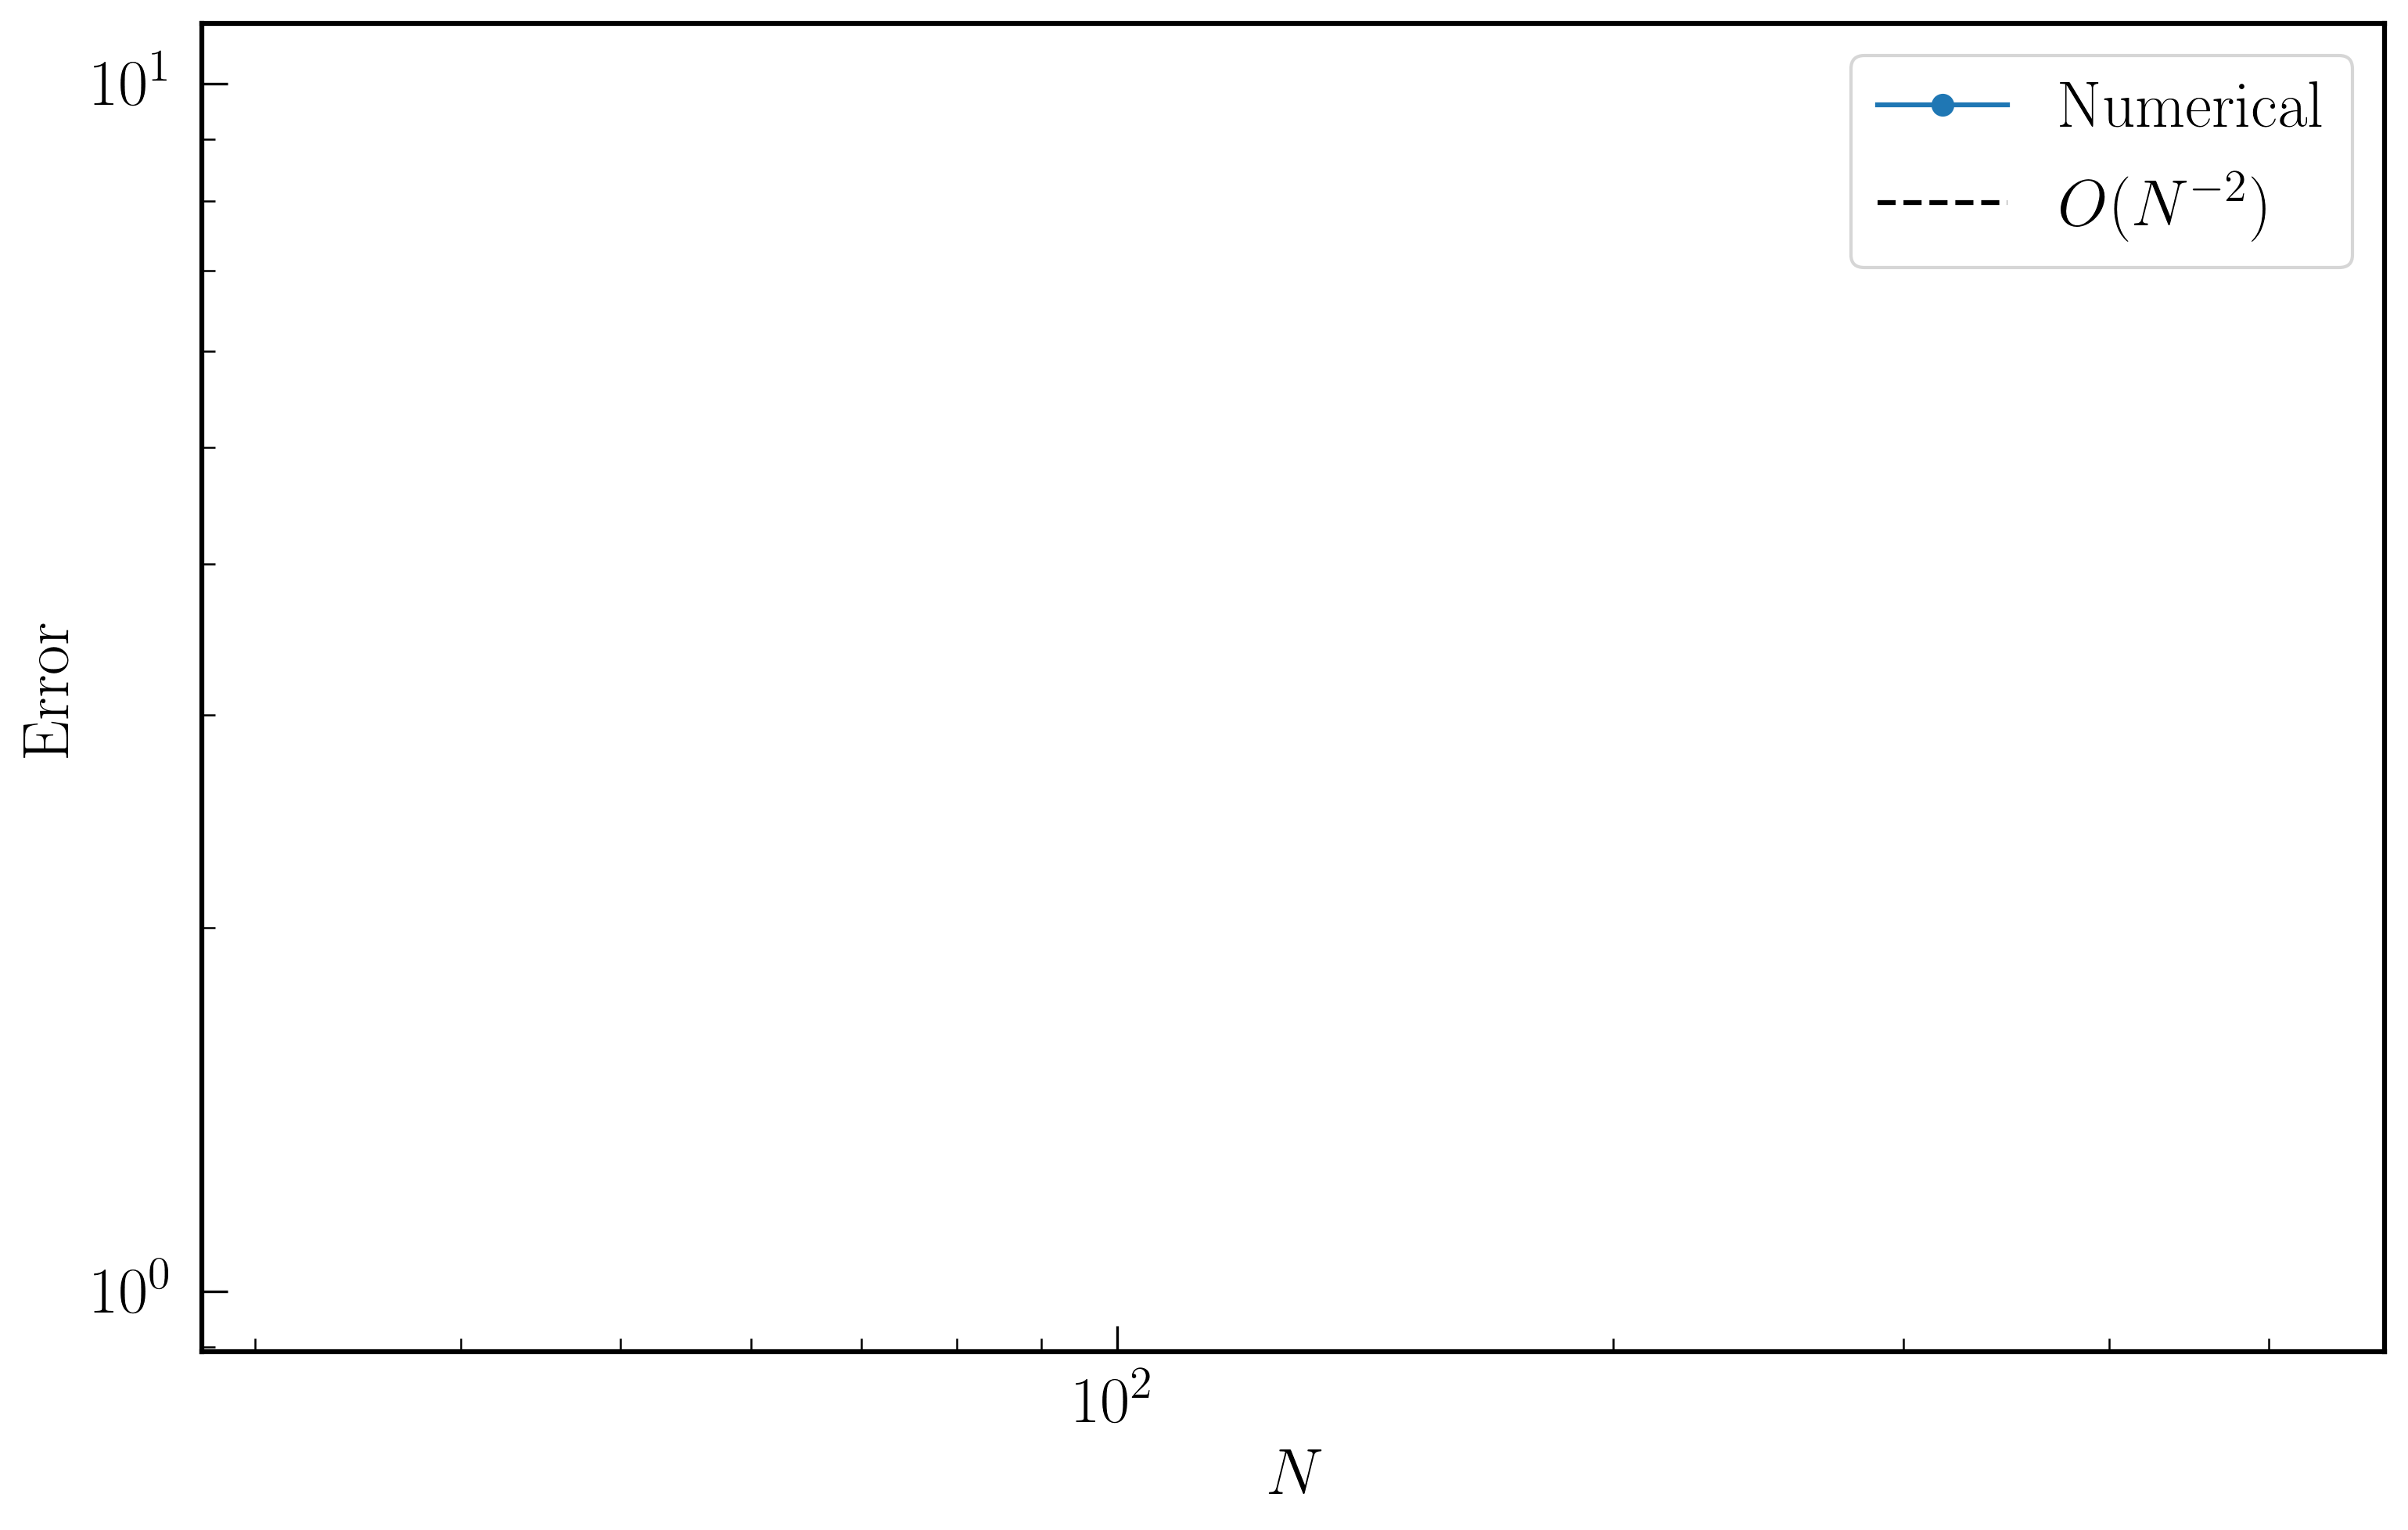

In [10]:
pl.loglog(N, error, 'o-', label = 'Numerical')
pl.loglog(N, error[0]*32**2/N**2, '--', color = 'black', 
          label = r'$O(N^{-2})$'
         )
pl.legend(loc = 'best')
pl.ylabel('Error')
pl.xlabel('$N$')
pl.savefig('convergence_plot.png')